# Analyse sémantique avec [BERTopic](https://maartengr.github.io/BERTopic/index.html)

BERTopic est un package python qui facilite la détection de sujets/thématiques dans des corpus par clustering d'embeddings.
Il permet d'imbriquer facilement des modèles et techniques existants (qu'il s'agisse de calcul d'embeddings, de réduction de dimensionalité, clustering, etc.).

Il offre une certaine flexibilité puisque l'utilisateur a la possibilité de choisir chaque brique du processus.

![](output/bert.svg "")

## Embeddings

- BERT: "*contextualized embeddings*" dérivés à travers un méchanisms d'attention, tirant partie des interactions entre plusieurs *tokens* dans une séquence (e.g. une phrase). Tâche d'entrainement: prédiction d'un mot masqué dans une séquence, à partir du contexte.
- SBERT: dérivation d'embeddings au niveau des phrases elle-même. Tâche d'entraînement: prédiction de similarité entre des paires de phrases.

De nombreux modèles pré-entraînés sur de très larges corpus sont disponibles. Ces grands corpus d'entraînement leur permettent de mieux appréhender la structure des langues couvertes. Si nécessaire, les modèles peut-être adaptés (fine-tuned) à un corpus particulier ou pour une tâche particulière.

### Limitations

 - Contexte limité (typiquement 128--512 tokens maximum)
 - Généralement adapté pour : similarité sémantique, clustering sémantique

## Réduction de dimensionalité 

 - [UMAP](https://pair-code.github.io/understanding-umap/index.html)
 - t-SNE
 - PCA (analyse en composantes principales)

## Clustering

 - [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

In [87]:
import pandas as pd
from bertopic import BERTopic
from matplotlib import pyplot as plt

# chargement des articles
df = pd.read_parquet("science/climate/articles.parquet", columns=["title", "publication_year"])

# retrait des articles dépourvus de titre
df.dropna(subset=["title"], inplace=True)
df.sample(n=5)

title  \
article_id                                                      
2510331993  Low Ozone over Europe Doesn't Mean the Sky Is ...   
2980688792  What Drives the North Atlantic Oscillation’s T...   
2336019448  Effects of extreme global warming in northern ...   
3122489099  Sustainability through the Lens of Environment...   
4386513389  A Novel Part in the Swiss Army Knife for Linki...   

            publication_year  
article_id                    
2510331993              2016  
2980688792              2019  
2336019448              2015  
3122489099              2018  
4386513389              2023

## La méthode simple...

In [65]:
topic_model = BERTopic(
    verbose=True
)
topics, probs = topic_model.fit_transform(df["title"])

2025-04-22 12:45:52,468 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/516 [00:00<?, ?it/s]

2025-04-22 12:46:05,367 - BERTopic - Embedding - Completed ✓
2025-04-22 12:46:05,368 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 12:46:07,963 - BERTopic - Dimensionality - Completed ✓
2025-04-22 12:46:07,964 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 12:46:08,284 - BERTopic - Cluster - Completed ✓
2025-04-22 12:46:08,286 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-22 12:46:08,404 - BERTopic - Representation - Completed ✓


## 1. Calcul des embeddings

In [131]:
# calcul des sentence embeddings
# Modèle par défaut: https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = sentence_model.encode(df["title"], show_progress_bar=True)

Batches:   0%|          | 0/7200 [00:00<?, ?it/s]

Modèle multilingue
[[1.         0.97918344 0.91667676 0.6397258 ]
 [0.97918344 1.0000001  0.9452106  0.6486144 ]
 [0.91667676 0.9452106  1.0000001  0.7016692 ]
 [0.6397258  0.6486144  0.7016692  1.0000004 ]]
Modèle non-multilingue
[[ 1.          0.11672513  0.1469035  -0.00344787]
 [ 0.11672513  1.          0.37959933  0.6123262 ]
 [ 0.1469035   0.37959933  1.          0.38398886]
 [-0.00344787  0.6123262   0.38398886  1.        ]]


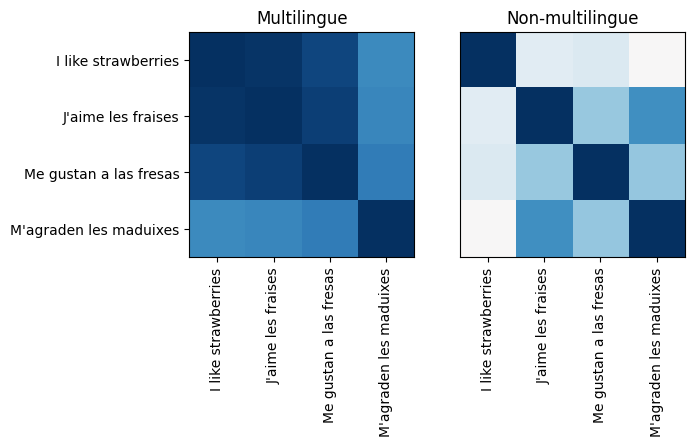

In [158]:
from sklearn.metrics.pairwise import cosine_distances

sentences = ["I like strawberries", "J'aime les fraises", "Me gustan a las fresas", "M'agraden les maduixes"]

# Multilingue
emb = sentence_model.encode(sentences)
multilingual_similarity = cosine_similarity(emb)
print("Modèle multilingue")
print(multilingual_similarity)

# Non multilingue
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(sentences)
normal_similarity = cosine_similarity(emb)
print("Modèle non-multilingue")
print(normal_similarity)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title("Multilingue")
ax.imshow(multilingual_similarity, cmap="RdBu", vmin=-1, vmax=+1)
ax.set_xticks([0, 1, 2, 3], sentences, rotation=90)
ax.set_yticks([0, 1, 2, 3], sentences)

ax = fig.add_subplot(122)
ax.set_title("Non-multilingue")
ax.imshow(normal_similarity, cmap="RdBu", vmin=-1, vmax=+1)
ax.set_xticks([0, 1, 2, 3], sentences, rotation=90)
ax.set_yticks([], [])
plt.show()

## 2. Réduction de dimensionalité

In [89]:
# algorithme de réduction de dimensionalité
from umap import UMAP
umap = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    low_memory=True,
    random_state=42
)

## 3. Clustering

In [100]:
# algorithme de clustering
from hdbscan import HDBSCAN
hdbscan = HDBSCAN(
    min_cluster_size=300,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## 4. Exécution de la pipeline

In [ ]:
topic_model = BERTopic(
    umap_model=umap,
    hdbscan_model=hdbscan
)
topics, probs = topic_model.fit_transform(
    df["title"],
    embeddings=embeddings,
)

In [116]:
topics[:5]

[-1, -1, 77, 4, 2]

In [127]:
df["topic"] = topics
df.tail(5)

title  \
article_id                                                      
4386855500  Accounting for time when estimating financed g...   
4389633312  Green sukuk in Saudi Arabia: Challenges and po...   
4389862110               ESG and Green Management in Thailand   
4389881210  To Enhance the Credibility of the Green Bond M...   
4390419499  The development of green finance in the EAEU c...   

            publication_year  topic  
article_id                           
4386855500              2023      4  
4389633312              2023     18  
4389862110              2023     -1  
4389881210              2023     -1  
4390419499              2023     18

In [159]:
df["topic"] = topic_model.reduce_outliers(
    df["title"],
    topics,
    strategy="embeddings",
    probabilities=probs,
    embeddings=embeddings
)
df.tail(5)

title  \
article_id                                                      
4386855500  Accounting for time when estimating financed g...   
4389633312  Green sukuk in Saudi Arabia: Challenges and po...   
4389862110               ESG and Green Management in Thailand   
4389881210  To Enhance the Credibility of the Green Bond M...   
4390419499  The development of green finance in the EAEU c...   

            publication_year  topic  
article_id                           
4386855500              2023      4  
4389633312              2023     18  
4389862110              2023     18  
4389881210              2023     18  
4390419499              2023     18

In [160]:
topic_model.get_topic_info()

Topic  Count                                              Name  \
0      -1  80557                                  -1_the_and_of_in   
1       0  24054  0_species_distribution_biodiversity_conservation   
2       1  12942               1_greenhouse_crop_yield_agriculture   
3       2  12018                2_climate_change_policy_adaptation   
4       3   6460                 3_permafrost_arctic_tundra_alaska   
..    ...    ...                                               ...   
81     80    336                 80_mental_health_change_wellbeing   
82     81    335           81_nepal_india_vulnerability_adaptation   
83     82    310              82_planetary_health_education_planet   
84     83    302                          83_eu_european_ets_union   
85     84    301                84_comment_on_comments_hess2020627   

                                       Representation  \
0   [the, and, of, in, on, for, to, climate, from,...   
1   [species, distribution, biodiversity, conserva...   
2   [greenhouse, crop, yield, agriculture, agricul...   
3   [climate, change, policy, adaptation, global, ...   
4   [permafrost, arctic, tundra, alaska, organic, ...   
..                                                ...   
81  [mental, health, change, wellbeing, climate, r...   
82  [nepal, india, vulnerability, adaptation, chan...   
83  [planetary, health, education, planet, medical...   
84  [eu, european, ets, union, sustainable, enviro...   
85  [comment, on, comments, hess2020627, hess20221...   

                                  Representative_Docs  
0   [Quantifying economic impact of tropical clima...  
1   [Integrated species distribution models: A com...  
2   [Event-based control for a greenhouse irrigati...  
3   [International Action on Climate Change Adapta...  
4   [Past permafrost dynamics can inform future pe...  
..                                                ...  
81  [Climate Change and Mental Health, Climate Cha...  
82  [Assessing the Livelihood Vulnerability of Rur...  
83  [Planetary health, Planetary Health, Planetary...  
84  [The impact of the EU ETS on firms' investment...  
85  [Comment on hess-2021-334, Comment on hess-202...  

[86 rows x 5 columns]

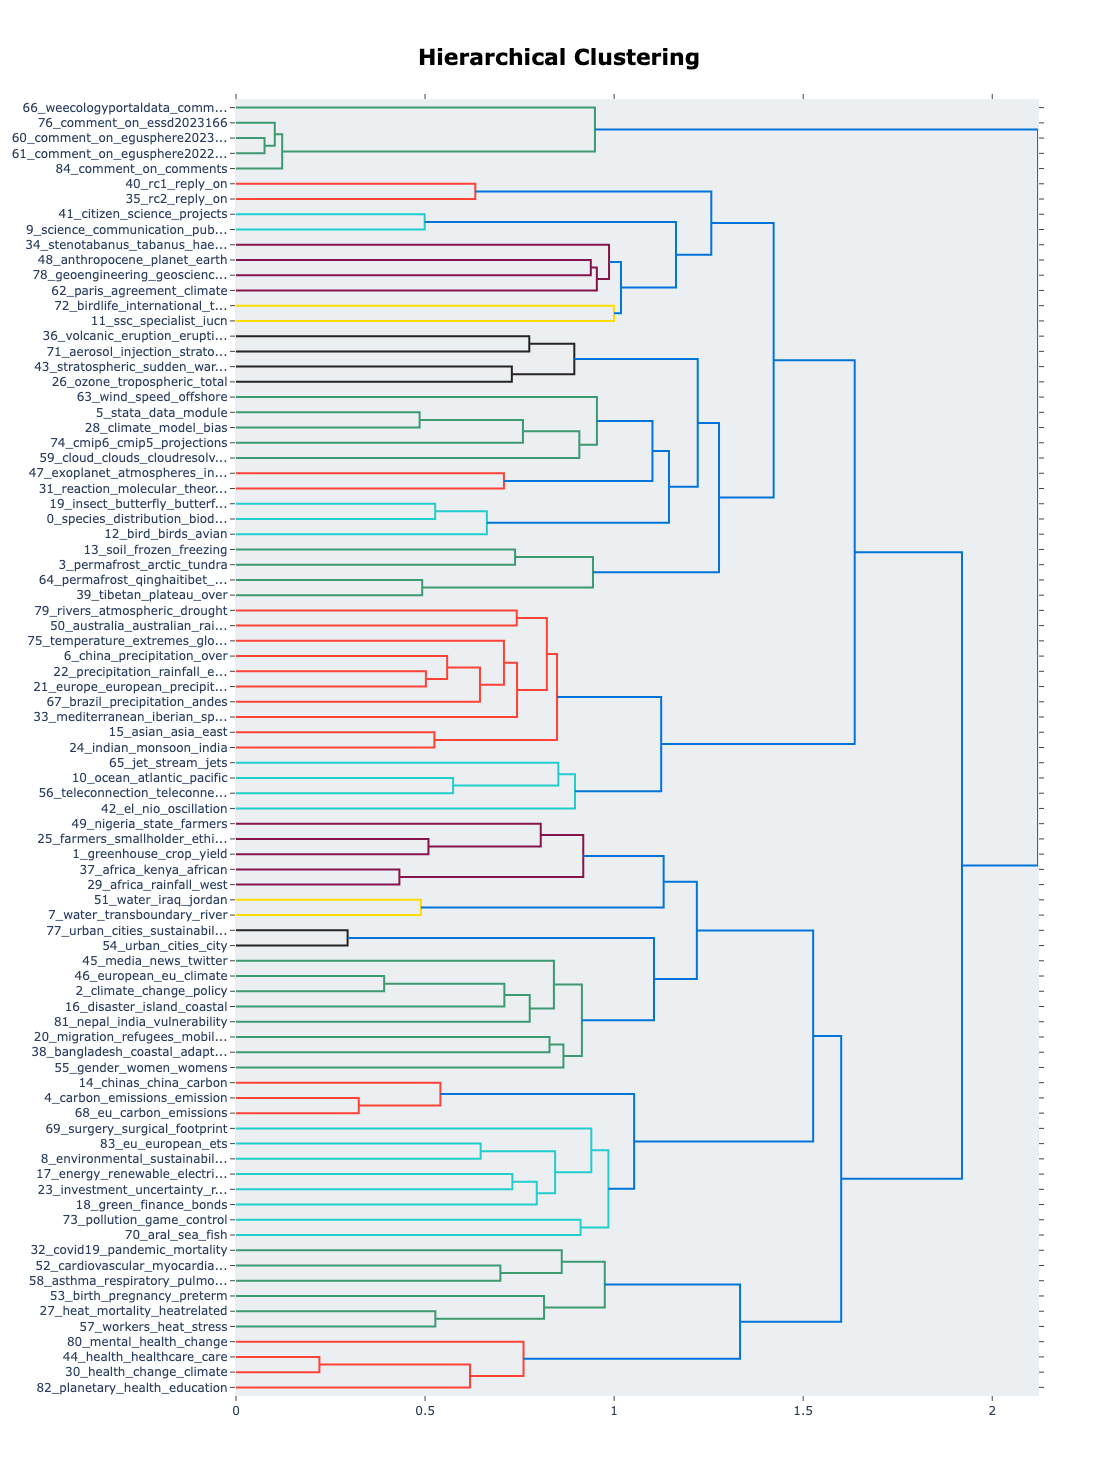

In [102]:
topic_model.visualize_hierarchy()

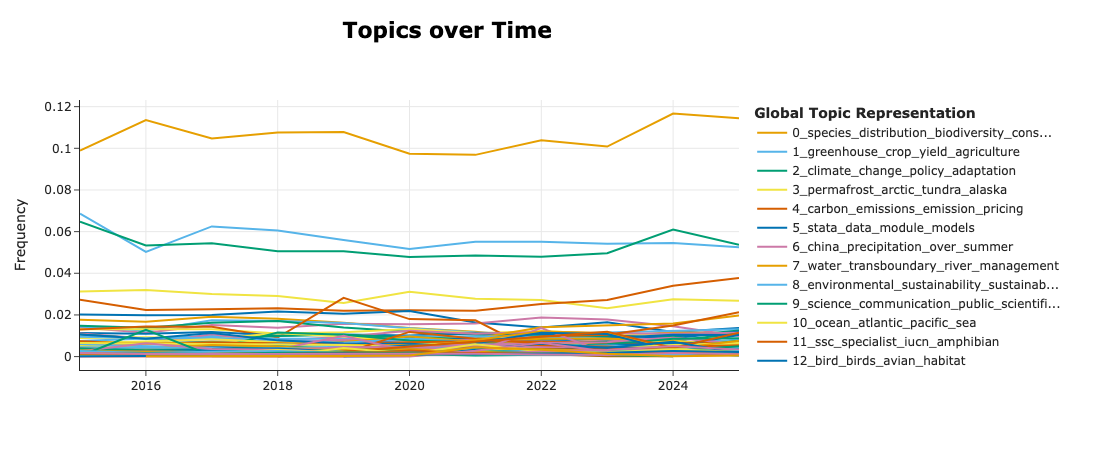

In [161]:
topics_over_time = topic_model.topics_over_time(df["title"], timestamps=df["publication_year"])
total_per_year = topics_over_time.groupby("Timestamp").agg(total=('Frequency', 'sum'))
topics_over_time = topics_over_time.merge(total_per_year, left_on="Timestamp", right_index=True)
topics_over_time["Frequency"] = topics_over_time["Frequency"]/topics_over_time["total"]
topic_model.visualize_topics_over_time(topics_over_time)

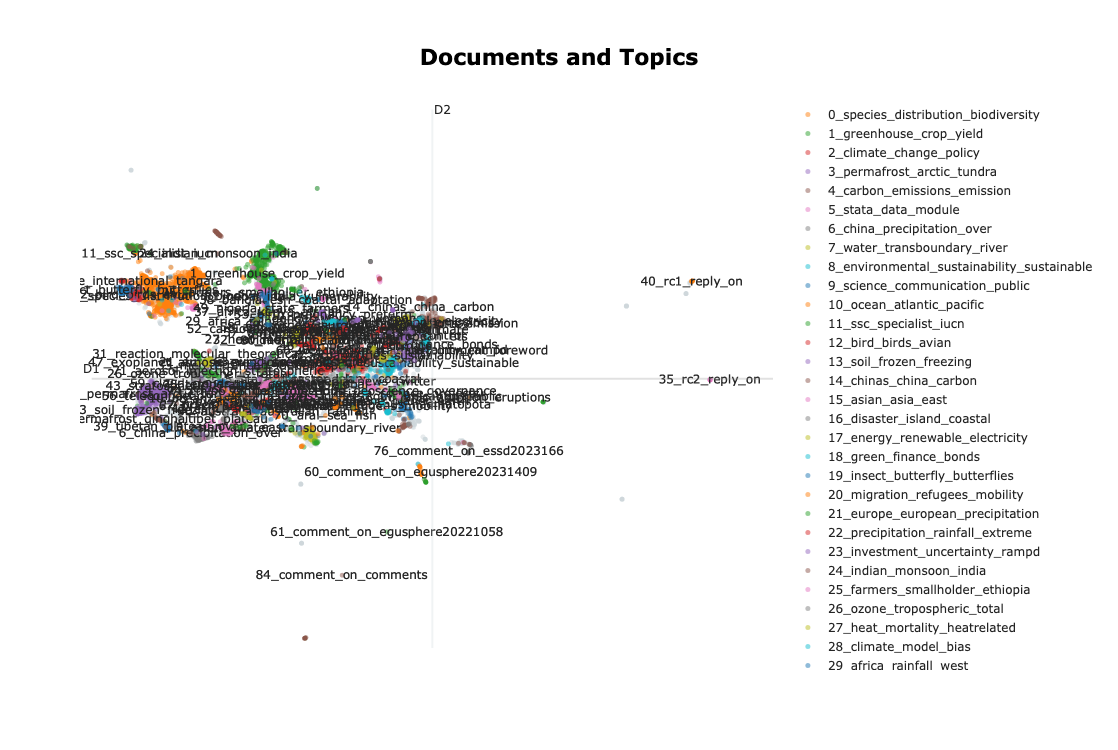

In [163]:
topic_model.visualize_documents(df["title"], embeddings=embeddings, sample=0.05)